In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.4_Baseline Individual Analyses/Output')

library("readxl")
library(tidyverse)
library(reshape2)
library(ggrepel)
library(data.table)

#reading in file
data_df <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




# Simulation

Simulating or choosing 500 random concentrations from each compartment and running spearman correlation tests to see if correlation between compartments persists given random noise. 

In [2]:
#finding average protein concentration by compartment for non-smokers only
#these represent the real data
smoking_status = c("NS", "CS", "Ecig")
final_correlation_table = data.frame()
for (i in 1:length(smoking_status)){
    NLF_conc = data_df %>% 
        filter(Compartment == 'NLF', Group == smoking_status[i]) %>%
        group_by(Protein) %>%
        summarize(mean = mean(Conc_pslog2))
    NELF_conc = data_df %>% 
        filter(Compartment == 'NELF', Group == smoking_status[i]) %>%
        group_by(Protein) %>%
        summarize(mean = mean(Conc_pslog2))
    Sputum_conc = data_df %>% 
        filter(Compartment == 'Sputum', Group == smoking_status[i]) %>%
        group_by(Protein) %>%
        summarize(mean = mean(Conc_pslog2))
    Serum_conc = data_df %>% 
        filter(Compartment == 'Serum', Group == smoking_status[i]) %>%
        group_by(Protein) %>%
        summarize(mean = mean(Conc_pslog2))

    #need to get 22 cytokine values 500 times
    #these represent simulated data
    NLF_permutations = c()
    NELF_permutations = c()
    Sputum_permutations = c()
    Serum_permutations = c()
    number_of_permutations = 500
    for (i in 1:number_of_permutations){
        #generating random concentrations
        NLF_random_conc = sample(NLF_conc$mean, replace = TRUE)
        NELF_random_conc = sample(NELF_conc$mean, replace = TRUE)
        Sputum_random_conc = sample(Sputum_conc$mean, replace = TRUE)
        Serum_random_conc = sample(Serum_conc$mean, replace = TRUE)

        #putting all iterations into a vector
        NLF_permutations = c(NLF_permutations, NLF_random_conc)
        NELF_permutations = c(NELF_permutations, NELF_random_conc)
        Sputum_permutations = c(Sputum_permutations, Sputum_random_conc)
        Serum_permutations = c(Serum_permutations, Serum_random_conc)
    }

    #changing dimensions where there are 22 cytokines (rows) and 500 perumutations (cols)
    dim(NLF_permutations) = c(22,number_of_permutations)
    dim(NELF_permutations) = c(22,number_of_permutations)
    dim(Sputum_permutations) = c(22,number_of_permutations)
    dim(Serum_permutations) = c(22,number_of_permutations)

    get_spearman_values = function(concentrations_comp1, concentrations_comp2){
        spearman_test = cor.test(concentrations_comp1, concentrations_comp2, method = c('spearman'))
        coeff = spearman_test$estimate
        pvalue = spearman_test$p.value
        value_tuple = c(coeff, pvalue)
        return(value_tuple)
    }

    #real data 
    NLF_NELF_tuple_real = get_spearman_values(NLF_conc$mean, NELF_conc$mean)
    NLF_Sputum_tuple_real = get_spearman_values(NLF_conc$mean, Sputum_conc$mean)
    NLF_Serum_tuple_real = get_spearman_values(NLF_conc$mean, Serum_conc$mean)
    NELF_Serum_tuple_real = get_spearman_values(NELF_conc$mean, Serum_conc$mean)
    NELF_Sputum_tuple_real = get_spearman_values(NELF_conc$mean, Sputum_conc$mean)
    Sputum_Serum_tuple_real = get_spearman_values(Sputum_conc$mean, Serum_conc$mean)

    get_spearman_values_looped_simulated = function(concentrations_comp1, concentrations_comp2){
        value_tuple_matrix = c()
        for (i in 1:number_of_permutations){
            spearman_test = cor.test(concentrations_comp1[,i], concentrations_comp2[,i], method = c('spearman'))
            coeff = spearman_test$estimate
            pvalue = spearman_test$p.value
            value_tuple = c(coeff, pvalue)
            value_tuple_matrix = rbind(value_tuple_matrix, value_tuple)
        }
        return(value_tuple_matrix)
    }

    # comparing simulated data across compartments
    NLF_NELF_tuple_simulated = get_spearman_values_looped_simulated(NLF_permutations, NELF_permutations)
    NLF_Sputum_tuple_simulated = get_spearman_values_looped_simulated(NLF_permutations, Sputum_permutations)
    NLF_Serum_tuple_simulated = get_spearman_values_looped_simulated(NLF_permutations, Serum_permutations)
    NELF_Serum_tuple_simulated = get_spearman_values_looped_simulated(NELF_permutations, Serum_permutations)
    NELF_Sputum_tuple_simulated = get_spearman_values_looped_simulated(NELF_permutations, Sputum_permutations)
    Sputum_Serum_tuple_simulated = get_spearman_values_looped_simulated(Sputum_permutations, Serum_permutations)

    #this is for real and simulated data
    get_spearman_values_looped_both = function(concentrations_comp1, concentrations_comp2){
        value_tuple_matrix = c()
        for (i in 1:number_of_permutations){
            spearman_test = cor.test(concentrations_comp1, concentrations_comp2[,i], method = c('spearman'))
            coeff = spearman_test$estimate
            pvalue = spearman_test$p.value
            value_tuple = c(coeff, pvalue)
            value_tuple_matrix = rbind(value_tuple_matrix, value_tuple)
        }
        return(value_tuple_matrix)
    }

    #comparing simulated data across compartments
    #version 1 (v1 has the first df as real and the second simulated vice versa for v2)
    NLF_NELF_tuple_real_simulated = get_spearman_values_looped_both(NLF_conc$mean, NELF_permutations)
    NLF_Sputum_tuple_real_simulated = get_spearman_values_looped_both(NLF_conc$mean, Sputum_permutations)
    NLF_Serum_tuple_real_simulated = get_spearman_values_looped_both(NLF_conc$mean, Serum_permutations)
    NELF_Serum_tuple_real_simulated = get_spearman_values_looped_both(NELF_conc$mean, Serum_permutations)
    NELF_Sputum_tuple_real_simulated = get_spearman_values_looped_both(NELF_conc$mean, Sputum_permutations)
    Sputum_Serum_tuple_real_simulated = get_spearman_values_looped_both(Sputum_conc$mean, Serum_permutations)

    #version 2
    NLF_NELF_tuple_simulated_real = get_spearman_values_looped_both(NELF_conc$mean, NLF_permutations)
    NLF_Sputum_tuple_simulated_real = get_spearman_values_looped_both(Sputum_conc$mean, NLF_permutations)
    NLF_Serum_tuple_simulated_real = get_spearman_values_looped_both(Serum_conc$mean, NLF_permutations)
    NELF_Serum_tuple_simulated_real = get_spearman_values_looped_both(Serum_conc$mean, NELF_permutations)
    NELF_Sputum_tuple_simulated_real = get_spearman_values_looped_both(Sputum_conc$mean, NELF_permutations)
    Sputum_Serum_tuple_simulated_real = get_spearman_values_looped_both(Serum_conc$mean, Sputum_permutations)

    #comparing real vs. simulated data within compartments
    NLF_NLF_tuple_real_simulated = get_spearman_values_looped_both(NLF_conc$mean, NLF_permutations)
    NELF_NELF_tuple_real_simulated = get_spearman_values_looped_both(NELF_conc$mean, NELF_permutations)
    Sputum_Sputum_tuple_real_simulated = get_spearman_values_looped_both(Sputum_conc$mean, Sputum_permutations)
    Serum_Serum_tuple_real_simulated = get_spearman_values_looped_both(Sputum_conc$mean, Serum_permutations)

    real_names = c('NLF vs. NELF', 'NLF vs. Sputum','NLF vs. Serum','NELF vs. Serum','NELF vs. Sputum','Sputum vs. Serum')
    real_sim_names = c('NLF vs. NELF Permuted', 'NLF vs. Sputum Permuted','NLF vs. Serum Permuted','NELF vs. Serum Permuted','NELF vs. Sputum Permuted','Sputum vs. Serum Permuted')
    sim_real_names = c('NLF Permuted vs. NELF', 'NLF Permuted vs. Sputum','NLF Permuted vs. Serum','NELF Permuted vs. Serum','NELF Permuted vs. Sputum','Sputum Permuted vs. Serum')
    simulated_names = c('NLF Permuted vs. NELF Permuted', 'NLF Permuted vs. Sputum Permuted','NLF Permuted vs. Serum Permuted','NELF Permuted vs. Serum Permuted','NELF Permuted vs. Sputum Permuted','Sputum Permuted vs. Serum Permuted')

    # creating table w/ comparisons as rows and 3 col: coeff, p value, real or simulated data
    table_summary = function(tuple1, tuple2, tuple3, tuple4, tuple5, tuple6, data_type, names_vector){
        table_initial = rbind(tuple1, tuple2, tuple3, tuple4, tuple5, tuple6) #contains coeff, p values
        data_type_vector = rep(data_type, times = length(table_initial[,1])) #contains the type of values

        spearman_table = cbind(names_vector, table_initial, data_type_vector) #creating table
        colnames(spearman_table) = c('Compartment_Comparison','Spearman_Coefficient', 'P_Value', 'Data_Type')
        return(spearman_table)
    }

    #putting everything into a table
    real_correlations = table_summary(NLF_NELF_tuple_real, NLF_Sputum_tuple_real, NLF_Serum_tuple_real, NELF_Serum_tuple_real, 
                 NELF_Sputum_tuple_real, Sputum_Serum_tuple_real, 'Real', real_names)
    real_simulated_correlations = table_summary(NLF_NELF_tuple_real_simulated, NLF_Sputum_tuple_real_simulated, NLF_Serum_tuple_real_simulated, NELF_Serum_tuple_real_simulated, 
                 NELF_Sputum_tuple_real_simulated, Sputum_Serum_tuple_real_simulated, 'Real & Simulated', real_sim_names)
    simulated_real_correlations = table_summary(NLF_NELF_tuple_simulated_real, NLF_Sputum_tuple_simulated_real, NLF_Serum_tuple_simulated_real, NELF_Serum_tuple_simulated_real, 
                 NELF_Sputum_tuple_simulated_real, Sputum_Serum_tuple_simulated_real, 'Real & Simulated', sim_real_names)
    simulated_correlations = table_summary(NLF_NELF_tuple_simulated, NLF_Sputum_tuple_simulated, NLF_Serum_tuple_simulated, NELF_Serum_tuple_simulated, 
                 NELF_Sputum_tuple_simulated, Sputum_Serum_tuple_simulated, 'Simulated', simulated_names)

    real_names = c('NLF vs. NELF', 'NLF vs. Sputum','NLF vs. Serum','NELF vs. Serum','NELF vs. Sputum','Sputum vs. Serum')
    real_sim_names = c('NLF vs. NELF Permuted', 'NLF vs. Sputum Permuted','NLF vs. Serum Permuted','NELF vs. Serum Permuted','NELF vs. Sputum Permuted','Sputum vs. Serum Permuted')
    sim_real_names = c('NLF Permuted vs. NELF', 'NLF Permuted vs. Sputum','NLF Permuted vs. Serum','NELF Permuted vs. Serum','NELF Permuted vs. Sputum','Sputum Permuted vs. Serum')
    simulated_names = c('NLF Permuted vs. NELF Permuted', 'NLF Permuted vs. Sputum Permuted','NLF Permuted vs. Serum Permuted','NELF Permuted vs. Serum Permuted','NELF Permuted vs. Sputum Permuted','Sputum Permuted vs. Serum Permuted')

    # creating table w/ comparisons as rows and 3 col: coeff, p value, real or simulated data
    table_summary = function(tuple1, tuple2, tuple3, tuple4, tuple5, tuple6, data_type, names_vector){
        table_initial = rbind(tuple1, tuple2, tuple3, tuple4, tuple5, tuple6) #contains coeff, p values
        data_type_vector = rep(data_type, times = length(table_initial[,1])) #contains the type of values

        spearman_table = cbind(names_vector, table_initial, data_type_vector) #creating table
        colnames(spearman_table) = c('Compartment_Comparison','Spearman_Coefficient', 'P_Value', 'Data_Type')
        return(spearman_table)
    }

    #putting everything into a table
    real_correlations = table_summary(NLF_NELF_tuple_real, NLF_Sputum_tuple_real, NLF_Serum_tuple_real, NELF_Serum_tuple_real, 
                 NELF_Sputum_tuple_real, Sputum_Serum_tuple_real, 'Real', real_names)
    real_simulated_correlations = table_summary(NLF_NELF_tuple_real_simulated, NLF_Sputum_tuple_real_simulated, NLF_Serum_tuple_real_simulated, NELF_Serum_tuple_real_simulated, 
                 NELF_Sputum_tuple_real_simulated, Sputum_Serum_tuple_real_simulated, 'Real & Simulated', real_sim_names)
    simulated_real_correlations = table_summary(NLF_NELF_tuple_simulated_real, NLF_Sputum_tuple_simulated_real, NLF_Serum_tuple_simulated_real, NELF_Serum_tuple_simulated_real, 
                 NELF_Sputum_tuple_simulated_real, Sputum_Serum_tuple_simulated_real, 'Real & Simulated', sim_real_names)
    simulated_correlations = table_summary(NLF_NELF_tuple_simulated, NLF_Sputum_tuple_simulated, NLF_Serum_tuple_simulated, NELF_Serum_tuple_simulated, 
                 NELF_Sputum_tuple_simulated, Sputum_Serum_tuple_simulated, 'Simulated', simulated_names)

    table_summary_within_comp = function(tuple1, tuple2, tuple3, tuple4, data_type){
        table_initial = rbind(tuple1, tuple2, tuple3, tuple4) #contains coeff, p values
        compartment_comparison_vector = c('NLF vs. NLF', 'NELF vs. NELF','Sputum vs. Sputum','Serum vs. Serum')
        data_type_vector = rep(data_type, times = length(table_initial[,1])) #contains the type of values
        spearman_table = cbind(compartment_comparison_vector, table_initial, data_type_vector) #creating table
        colnames(spearman_table) = c('Compartment_Comparison','Spearman_Coefficient', 'P_Value', 'Data_Type')
        return(spearman_table)
    }
    #putting everything into a table
    real_correlations_within_comp = table_summary_within_comp(NLF_NLF_tuple_real_simulated, NELF_NELF_tuple_real_simulated, 
                                                              Sputum_Sputum_tuple_real_simulated, Serum_Serum_tuple_real_simulated, 
                                                              'Real & Simulated Within')

    correlation_table = data.frame(rbind(real_correlations, simulated_correlations, real_simulated_correlations,
                                              simulated_real_correlations, real_correlations_within_comp))

    #making coefficients and p values numeric
    #new r update doesn't allow for direct conversions from factors to numeric
    correlation_table$Spearman_Coefficient = as.numeric(as.character(correlation_table$Spearman_Coefficient))
    correlation_table$P_Value = as.numeric(as.character(correlation_table$P_Value))
    correlation_table$Smoking_Status = rep(smoking_status[i], times = length(correlation_table$P_Value))
    
    #adding to make one final df
    final_correlation_table = rbind(final_correlation_table, correlation_table)
}

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1[, i], concentrations_comp2[, :
“Cannot c

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(concentrations_comp1, concentrations_comp2[, :
“Cannot compute exact p-value with ties”
Warning 

In [10]:
final_correlation_table$Smoking_Status[1:11005] = "NS"
final_correlation_table$Smoking_Status[11006:22011] = "CS"
final_correlation_table$Smoking_Status[22012:33018] = "Ecig"
final_correlation_table$Smoking_Status = factor(final_correlation_table$Smoking_Status, levels = c("NS", "CS", "Ecig"))

In [11]:
head(final_correlation_table)

Compartment_Comparison Spearman_Coefficient P_Value      Data_Type
tuple1 NLF vs. NELF           0.9683794            3.501975e-06 Real     
tuple2 NLF vs. Sputum         0.8791643            2.472468e-06 Real     
tuple3 NLF vs. Serum          0.7346132            1.507782e-04 Real     
tuple4 NELF vs. Serum         0.7165443            2.612617e-04 Real     
tuple5 NELF vs. Sputum        0.9232072            4.079671e-06 Real     
tuple6 Sputum vs. Serum       0.7176736            2.528313e-04 Real     
       Smoking_Status
tuple1 NS            
tuple2 NS            
tuple3 NS            
tuple4 NS            
tuple5 NS            
tuple6 NS

# Plot

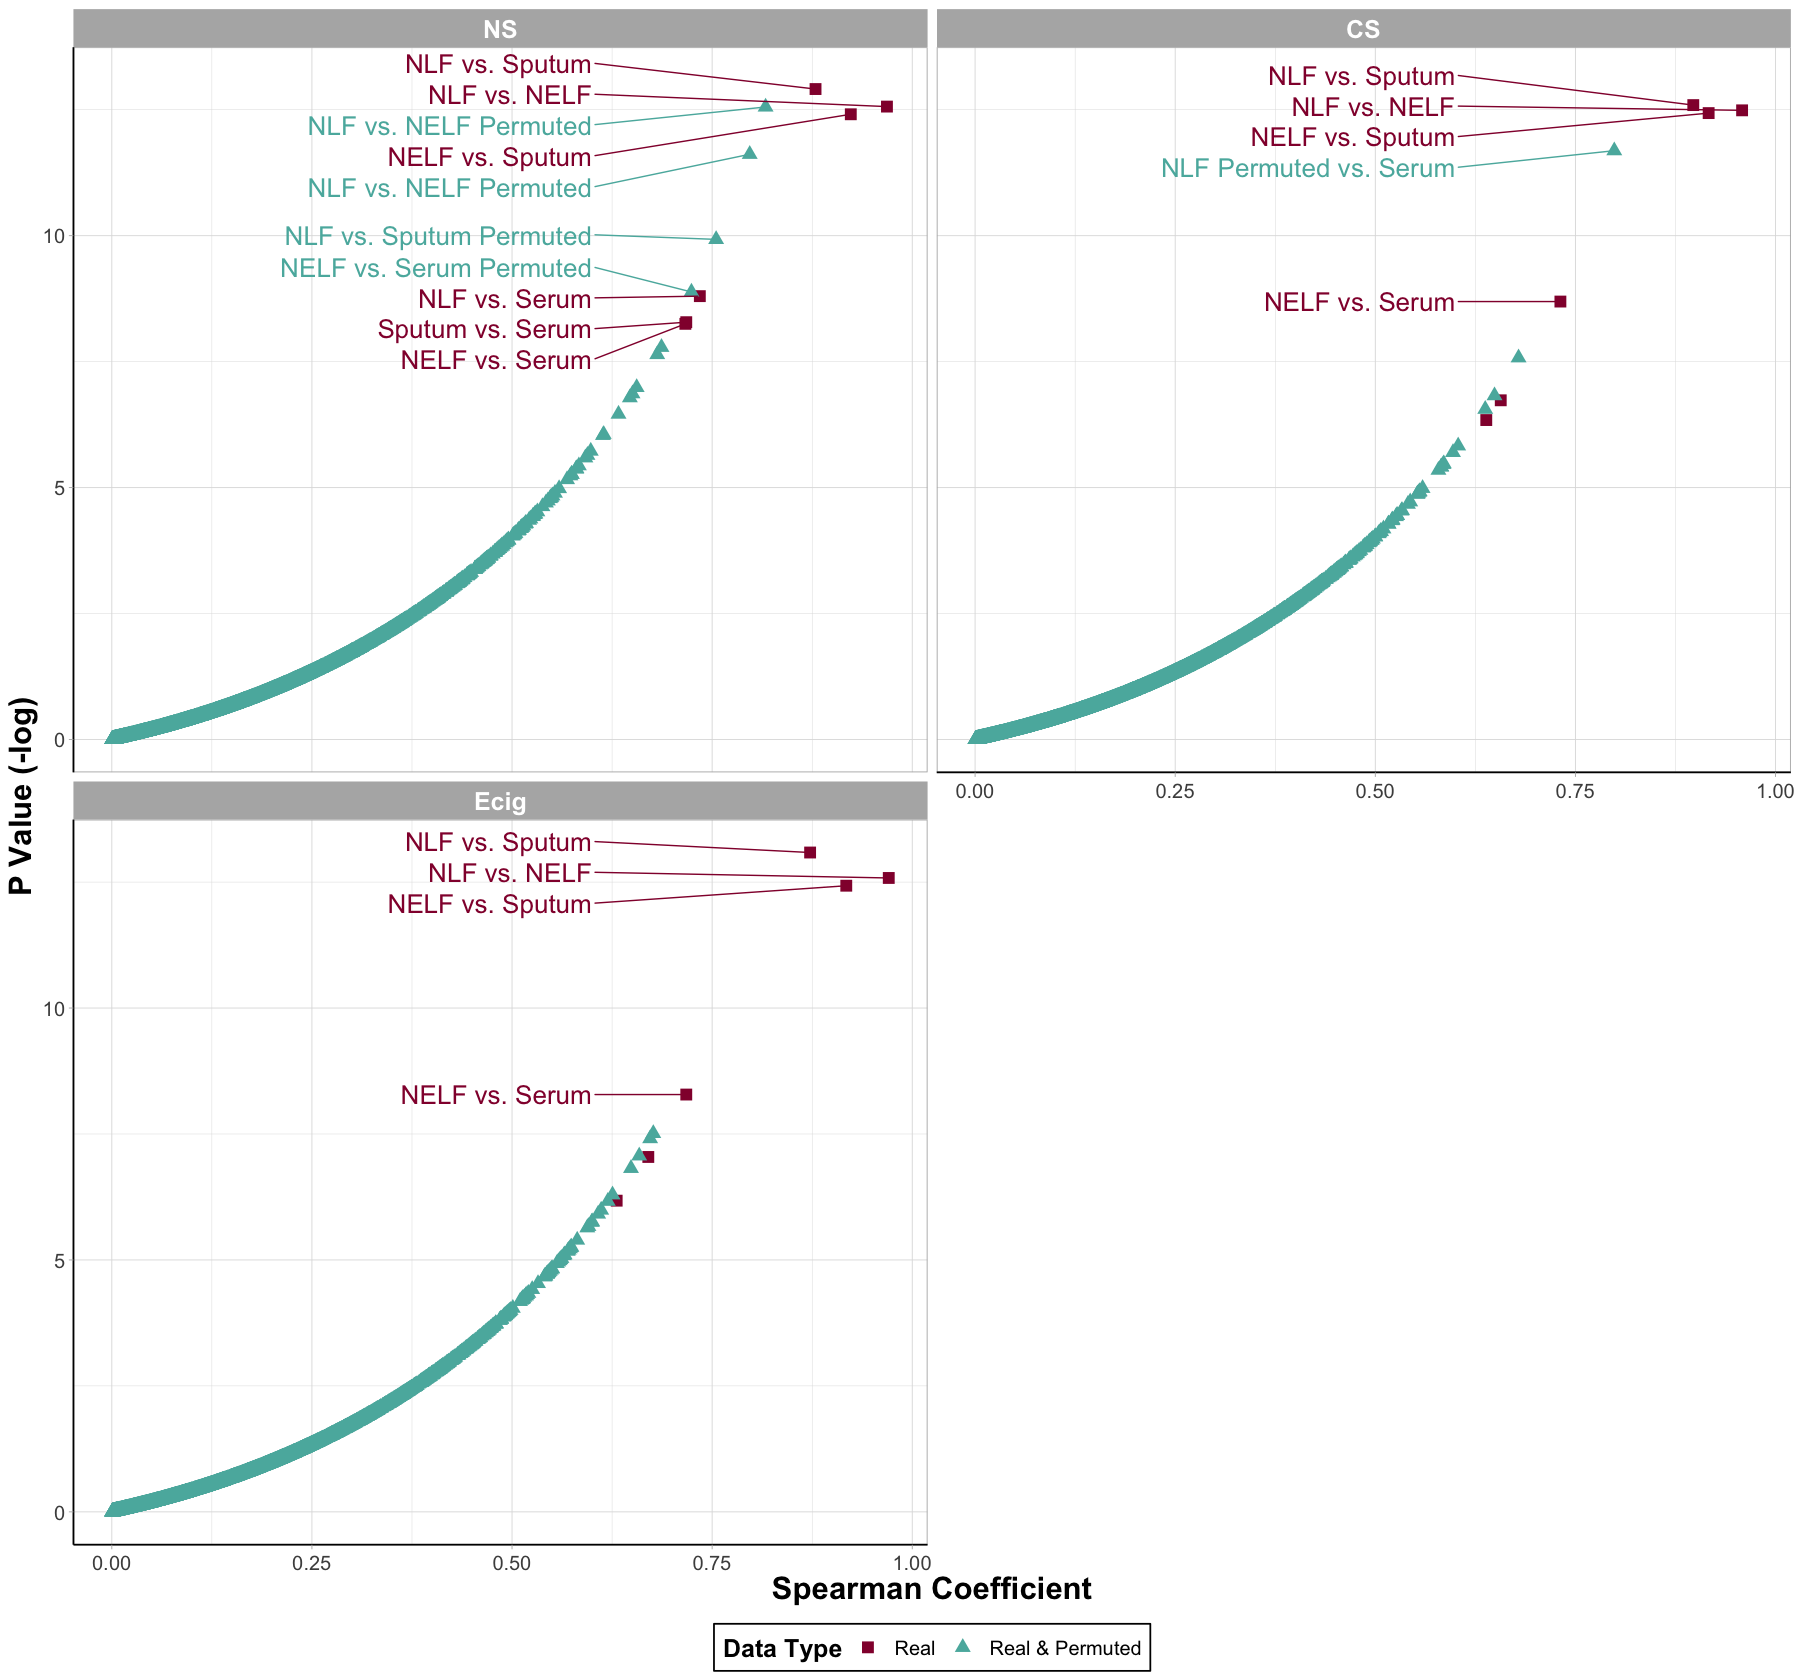

In [34]:
#creating a df with real data, real & simulated data compared across compartments for plotting
real_realsimulated_df = final_correlation_table %>% #removed this because this a within compartment comparison
             filter(Data_Type == 'Real'|Data_Type == 'Real & Simulated', Spearman_Coefficient > 0)
#creating a df with only signficant and highly correlated values
significant_df = real_realsimulated_df %>% 
    filter(Spearman_Coefficient > 0.7 & P_Value < 0.05)

options(repr.plot.width= 15, repr.plot.height= 14) #changing size
Figure2 = ggplot(data = real_realsimulated_df) + 
  geom_point(aes(x = Spearman_Coefficient, y = -log(P_Value), shape = Data_Type, color = Data_Type), size = 3) +

  #labeling points with statistical significance and a high level of correlation
  geom_text_repel(data = significant_df, 
    aes(x = Spearman_Coefficient, y = -log(P_Value), label = Compartment_Comparison, color = Data_Type),
    xlim = c(NA, 0.6),
    hjust = 1,
    segment.size = 0.4,
    size = 5.5, 
    show.legend = FALSE) +

  facet_wrap(~Smoking_Status, ncol = 2) + 

  theme_light() + 

#   theme(axis.line = element_line(colour="black"), #making x and y axes black
#         axis.text = element_text(size = 12),
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         legend.title = element_text(face="bold", size = 15),
#         legend.text = element_text(size = 12))+ #changes legend title
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Spearman Coefficient') + ylab('P Value (-log)') + #changing axis labels 

  scale_color_manual(name = 'Data Type',
                      values = c('#93003a','#5ab4ac'),#'#d8b365'
                      labels = c('Real','Real & Permuted')) + #reordering
  scale_shape_manual(name = 'Data Type',
                     values = c(15,17),
                     labels = c('Real','Real & Permuted'))
Figure2

In [35]:
#exporting
ggsave(Figure2, 
       filename = 'Figure2V2.pdf',
       path = Output,
       width = 15, height = 14) #maybe try 23x10 again

# Old Code

In [11]:
#creating a df with real data, real & simulated data compared across compartments for plotting
real_realsimulated_df = final_correlation_table %>% #removed this because this a within compartment comparison
             filter(Data_Type == 'Real'|Data_Type == 'Real & Simulated', Spearman_Coefficient > 0)
#creating a df with only signficant and highly correlated values
significant_df = real_realsimulated_df %>% 
    filter(Spearman_Coefficient > 0.7 & P_Value < 0.05)

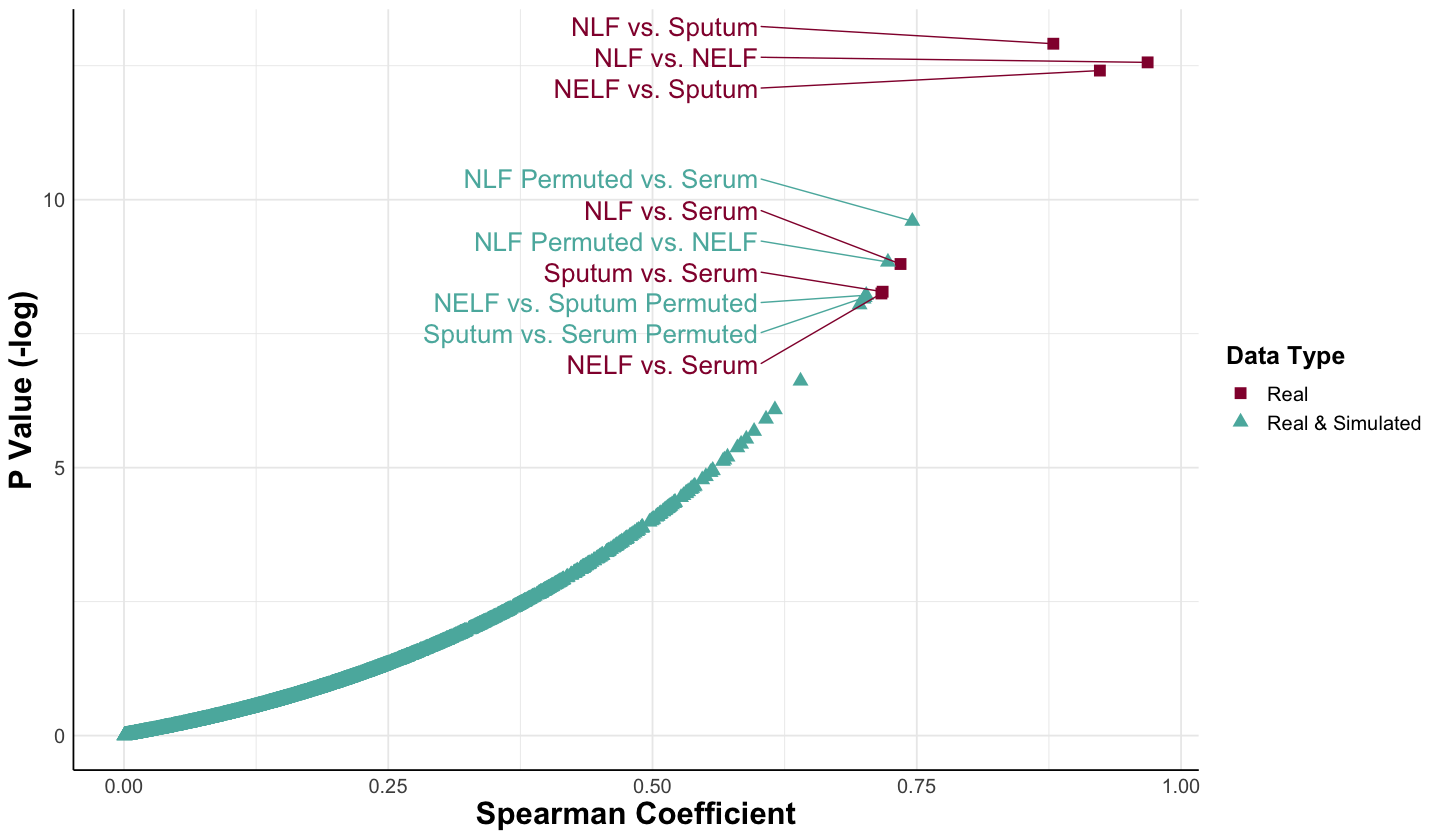

In [12]:
options(repr.plot.width= 12, repr.plot.height= 7) #changing size
Figure2 = ggplot(data = real_realsimulated_df) + 
  geom_point(aes(x = Spearman_Coefficient, y = -log(P_Value), shape = Data_Type, color = Data_Type), size = 3) +

  #labeling points with statistical significance and a high level of correlation
  geom_text_repel(data = significant_df, 
    aes(x = Spearman_Coefficient, y = -log(P_Value), label = Compartment_Comparison, color = Data_Type),
    xlim = c(NA, 0.6),
    hjust = 1,
    segment.size = 0.4,
    size = 5.5, 
    show.legend = FALSE) +

  theme_minimal() + 

  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face="bold", size = 15),
        legend.text = element_text(size = 12))+ #changes legend title
  xlab('Spearman Coefficient') + ylab('P Value (-log)') + #changing axis labels 

  scale_color_manual(name = 'Data Type',
                      values = c('#93003a','#5ab4ac'),#'#d8b365'
                      labels = c('Real','Real & Simulated')) + #reordering
  scale_shape_manual(name = 'Data Type',
                     values = c(15,17),
                     labels = c('Real','Real & Simulated'))
Figure2

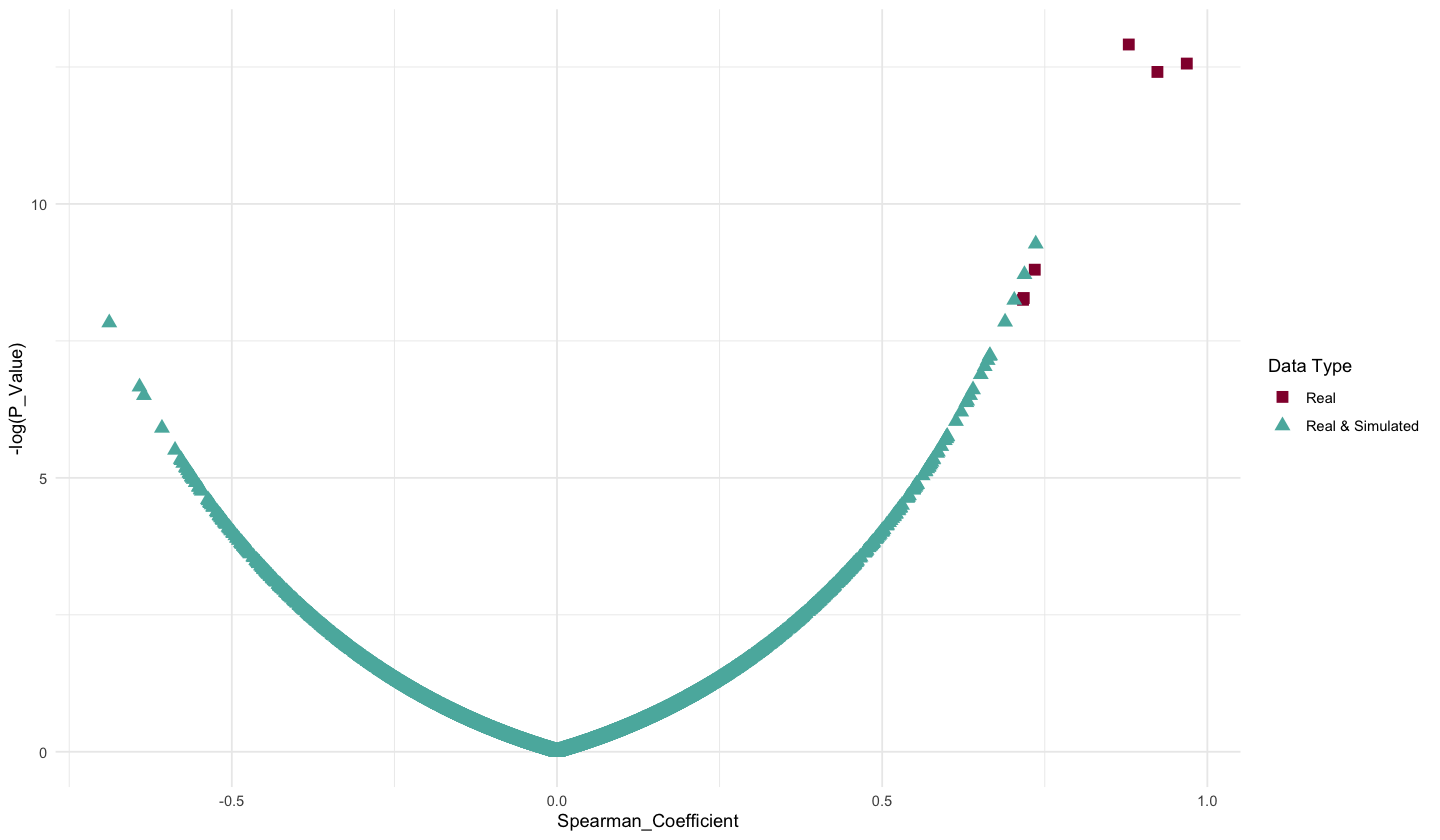

In [13]:
#just took a screenshot of this for the manuscript
ggplot(data = final_correlation_table %>%
      filter(Data_Type == 'Real'|Data_Type == 'Real & Simulated')) + 
  geom_point(aes(x = Spearman_Coefficient, y = -log(P_Value), shape = Data_Type, color = Data_Type), size = 3) + 
  theme_minimal() + 
  scale_color_manual(name = 'Data Type',
                      values = c('#93003a','#5ab4ac'),#'#d8b365'
                      labels = c('Real','Real & Simulated')) + #reordering
  scale_shape_manual(name = 'Data Type',
                     values = c(15,17),
                     labels = c('Real','Real & Simulated'))